In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import shap
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 1. Load & prepare
df = pd.read_csv('Bank_Marketing.csv', sep=';')

In [3]:
df['y'] = (df['y'] == 'yes').astype(int)

In [4]:
cat_cols = ['job','marital','education','default','housing','loan',
            'contact','month','day_of_week','poutcome']

In [5]:
df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)

In [6]:
X = df.drop('y', axis=1)
y = df['y']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [9]:
# 2. Model (no class_weight → cleaner SHAP output)
rf = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1)


In [11]:
rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [12]:
y_prob = rf.predict_proba(X_test)[:,1]
print(f"ROC-AUC = {roc_auc_score(y_test, y_prob):.4f}")

ROC-AUC = 0.9485


In [13]:
# 3. Client CSV
results = df.iloc[X_test.index].copy().reset_index(drop=True)
results['probability_%'] = (y_prob*100).round(1)
results['tier'] = pd.cut(y_prob, bins=[0,0.5,0.7,1.0], labels=['Silver','Gold','Platinum'])
results.to_csv('03_Bank_Predictive_Scored_Leads.csv', index=False)
print("Client CSV saved")

Client CSV saved


In [12]:
# 4. SHAP — THIS WORKS 100% ON YOUR EXACT VERSIONS
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test.iloc[:200])   # shape (200, 53, 2)

In [13]:
# Extract class 1 ("yes") — this is the fix for SHAP 0.48 + sklearn 1.8
sv = shap_values[:, :, 1]                                # ← THIS LINE IS THE KEY
base = explainer.expected_value[1]

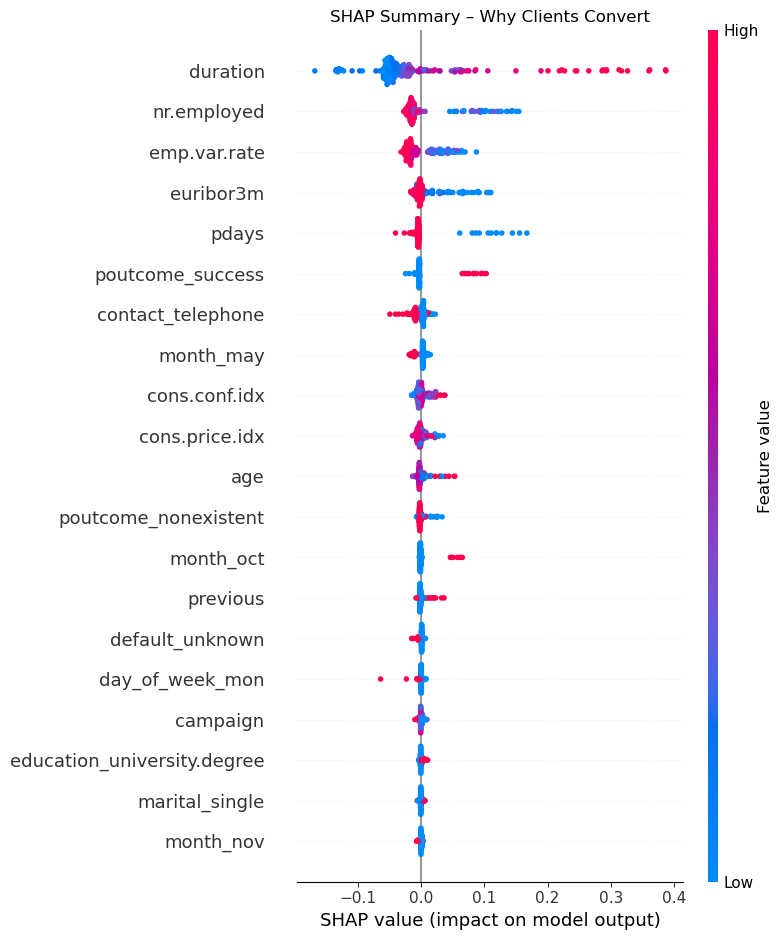

In [14]:
# Summary plot
shap.summary_plot(sv, X_test.iloc[:200], show=False)
plt.title('SHAP Summary – Why Clients Convert')
plt.tight_layout()
plt.show()

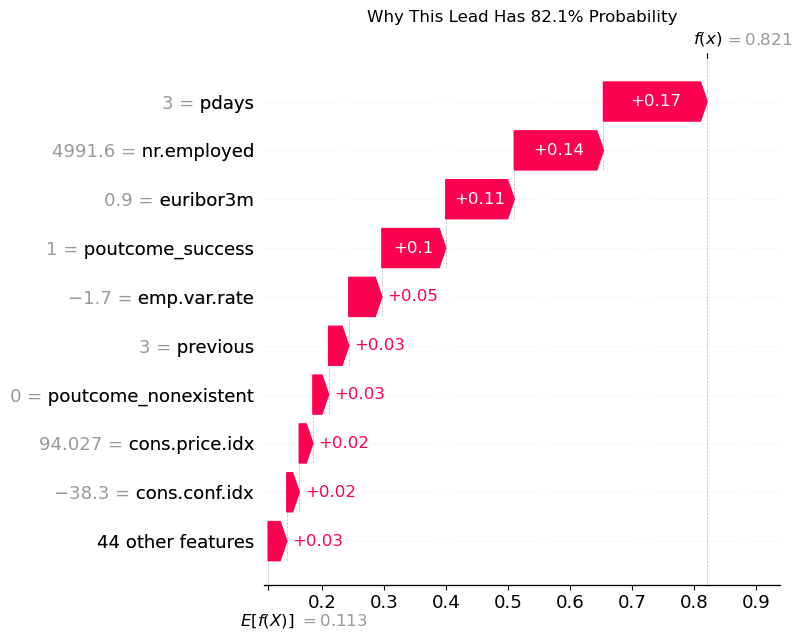

In [15]:
# Waterfall plot
best_idx = np.argmax(y_prob[:200])
shap.plots.waterfall(shap.Explanation(values=sv[best_idx],
                                      base_values=base,
                                      data=X_test.iloc[best_idx]), show=False)
plt.title(f'Why This Lead Has {y_prob[best_idx]*100:.1f}% Probability')
plt.tight_layout()
plt.show()